# Settings up a Network of calculations

## First load inputs

Here we're defining a list of ligands (each a `openfe.SmallMoleculeComponent`) from a single sdf,
and a protein from a PDB file.

In [1]:
import openfe
from rdkit import Chem
from openff.units import unit

In [2]:
# load ligands first into rdkit, then pass these into SmallMoleculeComponent containers
rdkit_ligands = list(Chem.SDMolSupplier('./inputs/Jnk1_ligands.sdf', removeHs=False))
ligands = [openfe.SmallMoleculeComponent.from_rdkit(l) for l in rdkit_ligands]

# protein straight from PDB to ProteinComponent
protein = openfe.ProteinComponent.from_pdb_file('./inputs/181L_mod_capped_protonated.pdb')

# define the abstract solvent
solvent = openfe.SolventComponent(
    positive_ion='Na', negative_ion='Cl',
    neutralize=True, ion_concentration=0.15*unit.molar
)

In [3]:
len(ligands)

21

## Define edges and mappings

Define the edges we wish to run,
each requiring a `LigandAtomMapping`,
generated by the `LomapAtomMapper`.

In [4]:
# give indices of all edges you want Lomap to form
# indices refer to the position within the variable `ligands`
edges = [
    (0, 1),
]

mapper = openfe.LomapAtomMapper(element_change=False,  # forbid element changes
                                time=300,  # large timeout
                                max3d=0.5)  # max 3d deviation

mappings = [
    next(mapper.suggest_mappings(ligands[i], ligands[j])) for i, j in edges
]

In [5]:
# fix up mappings
# Lomap currently allows some mismatches of >0.5 for hydrogens so remove these
fixed_mappings = []
for mapping in mappings:
    dists = mapping.get_distances()
    
    m = {i: j for (i, j), d in zip(mapping.componentA_to_componentB.items(), dists)
         if d < 0.5}
    
    fixed_mappings.append(
        openfe.LigandAtomMapping(componentA=mapping.componentA,
                                 componentB=mapping.componentB,
                                 componentA_to_componentB=m
                                )
    )
mappings = fixed_mappings

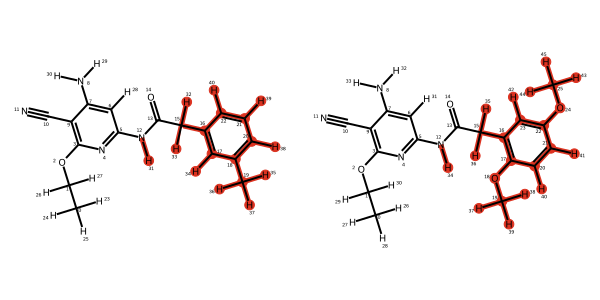

In [6]:
mappings[0]

In [7]:
from openfe.utils.visualization_3D import show_3D_mapping

In [8]:
show_3D_mapping(mappings[0], show_atomIDs=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Define what we will do to each edge (the Protocol)

In [9]:
from openfe.protocols import openmm_rbfe


In [15]:
# generate default starting settings
# these are relatively sane, but can be tweaked
settings = openmm_rbfe.RelativeLigandProtocol.default_settings()

# tweak to hearts content
settings.simulation_settings.equilibration_length = 6 * unit.picosecond
settings.simulation_settings.production_length = 6 * unit.picosecond
settings.sampler_settings.n_repeats = 1  # number of completely independent runs, variance is std of means of these

# put Settings into Protocol
# the settings are now "locked in"/read-only and can't be further modified
# this is deliberate, the Protocol is now a fixed record of what you will do/have done
prot = openmm_rbfe.RelativeLigandProtocol(settings)

## Apply Protocol onto Edges

For each edge we wanted to calculate, 
create both a solvent-only and complex `ChemicalSystem` by combining the various `Component`s we previously defined.
Then create a `Transformation` for each leg of the RBFE,
using the same `Protocol` object for each.

This creates a list of `Transformation` objects for both solvent and complex legs.

In [16]:
# build both a solvent and complex network
solvent_transforms = []
complex_transforms = []

for mapping in mappings:
    # solvent systems
    solv_sysA = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentA})
    solv_sysB = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentB})
    
    # complex systems
    comp_sysA = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentA,
                                     'protein': prot})
    comp_sysB = openfe.ChemicalSystem({'solvent': solvent, 'ligand': mapping.componentB,
                                     'protein': prot})
    
    solv_trans = openfe.Transformation(stateA=solv_sysA, stateB=solv_sysB,
                                      protocol=prot, mapping={'ligand': mapping})
    comp_trans = openfe.Transformation(stateA=comp_sysB, stateB=comp_sysB,
                                      protocol=prot, mapping={'ligand': mapping})
    
    solvent_transforms.append(solv_trans)
    complex_transforms.append(comp_trans)

## Write out Transformations

To farm out the jobs to multiple processes,
write the `Transformation` object to a json file on disk.

Creates a directory structure like this:

```
- work_rootdir/
  for each ligand pair:
  - {ligandA_name}_{ligandB_name}/
    - solvent/
      - transformation.json
    - complex/
      - transformation.json
```

In [17]:
!rm -r work_rootdir

In [18]:
import os

rootname = 'work_rootdir'

os.mkdir(rootname)

for mapping, solv, comp in zip(mappings, solvent_transforms, complex_transforms):
    # requires that the Ligands have useful names
    # currently these are taken from the sdf file
    # but could also be set using `SmallMoleculeComponent(..., name="something")` on creation
    edgename = '{}_{}'.format(mapping.componentA.name, mapping.componentB.name)
    
    os.mkdir(os.path.join(rootname, edgename))
    
    os.mkdir(os.path.join(rootname, edgename, 'solvent'))
    solv.dump(os.path.join(rootname, edgename, 'solvent', 'transformation.json'))
    
    os.mkdir(os.path.join(rootname, edgename, 'complex'))
    comp.dump(os.path.join(rootname, edgename, 'complex', 'transformation.json'))


# Running the simulations

In each directory listed above, and run `openfe quickrun transformation.json -o results.json`

This will create a file called `results.json` containing the results of all repeats for a given leg.

The results can be loaded using json, by passing the `JSON_HANDLER.decoder` from `gufe` to assist in interpreting the special objects encoded within.

In [26]:
import gufe
import json

results = json.load(open('./work_rootdir/18629-1_18634-1/solvent/results.json', 'r'),
                    cls=gufe.tokenization.JSON_HANDLER.decoder)

In [27]:
results['estimate']

-37.122225993429346 <Unit('kilocalorie / mole')>

In [28]:
results['uncertainty']

0.0 <Unit('kilocalorie / mole')>

In [29]:
results

{'estimate': -37.122225993429346 <Unit('kilocalorie / mole')>,
 'uncertainty': 0.0 <Unit('kilocalorie / mole')>,
 'protocol_result': {'data': {'nc_files': [{'nc_paths': [PosixPath('/home/richard/code/ExampleNotebooks/openmm-rbfe/work_rootdir/18629-1_18634-1/solvent/b3553b40-afb1-4964-9ff2-70a391b5e13c/rbfe.nc')],
     'checkpoint_paths': [PosixPath('/home/richard/code/ExampleNotebooks/openmm-rbfe/work_rootdir/18629-1_18634-1/solvent/b3553b40-afb1-4964-9ff2-70a391b5e13c/rbfe_checkpoint.nc')]}]},
  '__qualname__': 'RelativeLigandProtocolResult',
  '__module__': 'openfe.protocols.openmm_rbfe.equil_rbfe_methods'},
 'unit_results': {'ProtocolUnitResult-90d6ef81a5a544b18c6e82409fffea5c': {'name': '18629-1 18634-1 repeat 0 generation 0',
   '_key': 'ProtocolUnitResult-90d6ef81a5a544b18c6e82409fffea5c',
   'source_key': 'RelativeLigandProtocolUnit-9b1874e65cdd45bc9a0fcf3f53da76ce',
   'inputs': {'stateA': {':gufe-key:': 'ChemicalSystem-09116f8ff41afa43c99d7ec2ef01c43f'},
    'stateB': {':gufe-